##### Disclaimer : 
This notebook was originally created and used on Google Collab. In order for it to run on a normal computer, I reworked it. However I wanted to leave the Google Collab parts. These code cells will be marked with #### DO NOT RUN ####.

In this notebook you will find the procedure for training a neural network. However the training time being especially long, the 3 re-trained models have been saved and are therefore loaded at the end of this notebook for performance evaluation.

# I - Prepare the data

### Import the dataset from Google Drive 


In [1]:
############################################
########## DO NOT RUN   ####################
############################################

from google.colab import drive
import os

drive.mount('/content/gdrive)'


train_dir = 'gdrive/MyDrive/Colab Notebooks/train/'
test_dir = 'gdrive/MyDrive/Colab Notebooks/test/'

train_ratio = 0.8
test_ratio = 0.2

dataset_dir = gdrive/MyDrive/Colab Notebooks//dataset/105_classes_pins_dataset'
dir_list = os.listdir(dataset_di))

Mounted at /content/gdrive


In [1]:
import os

train_dir = 'train/'
test_dir = 'test/'

train_ratio = 0.8
test_ratio = 0.2

dataset_dir = 'dataset/105_classes_pins_dataset'
dir_list = os.listdir(dataset_dir)

### Split the dataset 

In [ ]:
############################################
########## DO NOT RUN   ####################
############################################

from shutil import copyfile
import numpy as np
    

for folder in dir_list:
    data_dir = os.listdir(dataset_dir + '/' + folder)
    np.random.shuffle(data_dir)                         
    os.makedirs(train_dir + '/' + folder, exist_ok=True)
    os.makedirs(test_dir + '/' + folder, exist_ok=True)
    train_data = data_dir[:int(len(data_dir) * train_ratio + 1)] 
    test_data = data_dir[-int(len(data_dir) * test_ratio):]
  
    for image in train_data:
        copyfile(dataset_dir + '/' + folder + '/' + image, train_dir + '/' + folder + '/' + image) #Copying the Training files from dataset to training directory.
    
    for image in test_data:
        copyfile(dataset_dir + '/' + folder + '/' + image , test_dir + '/' + folder + '/' + image)  #Copying the Training files from dataset to training directory.

In [ ]:
print('Number of classes for training : ', len(os.listdir(train_dir)))
print('Number of classes for testing : ', len(os.listdir(test_dir)))
print('')
print('The Number of Examples in the Class="Katherine Langford" in the Dataset Directory: ', len(os.listdir(dataset_dir + '/Katherine Langford')))
print('The Number of Examples in the Class="Katherine Langford" in the Train Directory: ', len(os.listdir(train_dir + '/Katherine Langford')))
print('The Number of Examples in the Class="Katherine Langford" in the Test Directory: ', len(os.listdir(test_dir + '/Katherine Langford')))

### Configure online data augmentation

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

rows = 160  #Number of Pixels in the Rows for Input. 
cols = 160  #Number of Pixels in Columns for Output

train_datagen = ImageDataGenerator(rescale=1/255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   rotation_range=40,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)
                                 
test_datagen = ImageDataGenerator(rescale=1/255)

#Generator of the training dataset
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(rows,cols),
                                                    class_mode='categorical')
#Generator of the testing dataset
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(rows,cols),
                                                  class_mode='categorical')

Found 14085 images belonging to 105 classes.
Found 3463 images belonging to 105 classes.


# II - Import, tune and train the model
In this part, the example is the Xception model. 
In reality, I used this part with each model and saved the trained model obtained.

### Import the model from Keras (without last layer)

In [3]:
from tensorflow.keras.applications import Xception

#Load the model, without the top layer
special_model = Xception(input_shape=(rows, cols, 3),           
                            include_top=False,
                            weights='imagenet')   

print(len(special_model.layers))
#Allow us to retrain the model
special_model.trainable = True  
    
special_model.summary()

132
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 79, 79, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 79, 79, 32)   0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

### Add the last layers of the model

In [4]:
#Get the last layer of the model and save its output
last_layer_output = special_model.output

x = tf.keras.layers.GlobalAveragePooling2D()(last_layer_output)
#Add a Dropout layer.
x = tf.keras.layers.Dropout(0.8)(x)                      
# Add a final softmax layer for classification.
x = tf.keras.layers.Dense(105, activation='softmax')(x)

model = tf.keras.Model(special_model.input, x) 

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 79, 79, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 79, 79, 32)   0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

### Train the model

In [42]:
result = model.fit(train_generator,
                   validation_data=test_generator,
                   epochs=20,
                   verbose=1)

Epoch 1/20
441/441 [==============================] - 166s 368ms/step - loss: 4.6617 - accuracy: 0.0129 - val_loss: 4.1453 - val_accuracy: 0.0710
Epoch 2/20
441/441 [==============================] - 161s 364ms/step - loss: 4.0317 - accuracy: 0.0905 - val_loss: 2.8017 - val_accuracy: 0.2960
Epoch 3/20
441/441 [==============================] - 161s 364ms/step - loss: 2.9453 - accuracy: 0.2675 - val_loss: 1.9692 - val_accuracy: 0.4843
Epoch 4/20
441/441 [==============================] - 160s 363ms/step - loss: 2.1868 - accuracy: 0.4399 - val_loss: 1.4702 - val_accuracy: 0.6133
Epoch 5/20
441/441 [==============================] - 160s 363ms/step - loss: 1.5777 - accuracy: 0.5935 - val_loss: 1.2038 - val_accuracy: 0.6806
Epoch 6/20
441/441 [==============================] - 160s 362ms/step - loss: 1.1783 - accuracy: 0.6927 - val_loss: 0.9362 - val_accuracy: 0.7514
Epoch 7/20
441/441 [==============================] - 160s 362ms/step - loss: 0.8950 - accuracy: 0.7660 - val_loss: 0.8085 -

### Save the model and its results

In [43]:
############################################
########## DO NOT RUN   ####################
############################################
import pickle
import sys
#Save the model
model.save('gdrive/MyDrive/Colab Notebooks/XceptionModel')


#Save the results
file_to_store = open('gdrive/MyDrive/Colab Notebooks/XceptionMochsHistory.pkl', 'wb')
pickle.dump(result.history, file_to_store)
file_to_store.clEpochs')

INFO:tensorflow:Assets written to: gdrive/MyDrive/Colab Notebooks/XceptionModel20Epochs/assets


# III -  Evaluate the 3 models

### Import the saved models and its results

In [8]:
import pickle
from tensorflow import keras

#Import saved models
mobileNetV2 = keras.models.load_model('data/models/MobileNetV2Model')
resNet50V2 = keras.models.load_model('data/models/ResNet50V2Model')
xception = keras.models.load_model('data/models/XceptionModel')

#Import saved models history
file_to_read = open('data/histories/MobileNetV2History.pkl', "rb")
mobileNetV2History = pickle.load(file_to_read)
file_to_read.close()
file_to_read = open('data/histories/ResNet50V2History.pkl', "rb")
resNet50V2History = pickle.load(file_to_read)
file_to_read.close()
file_to_read = open('data/histories/XceptionHistory.pkl', "rb")
xceptionHistory = pickle.load(file_to_read)
file_to_read.close()

### Determine accuracy and execution time over the testing dataset

In [46]:
import numpy as np
from keras.preprocessing import image

print('MobileNetV2 :')
test_mobileNetV2 = mobileNetV2.evaluate(test_generator)[1]

print('ResNet50V2')
test_resNet50V2 = resNet50V2.evaluate(test_generator)[1]

print('Xception :')
test_xception = xception.evaluate(test_generator)[1]

MobileNetV2 :
109/109 [==============================] - 9s 84ms/step - loss: 0.8384 - accuracy: 0.7892
ResNet50V2
109/109 [==============================] - 10s 89ms/step - loss: 0.7400 - accuracy: 0.8085
Xception :
109/109 [==============================] - 11s 93ms/step - loss: 0.5324 - accuracy: 0.8649


### Plot the accuracy of each models over the training epochs

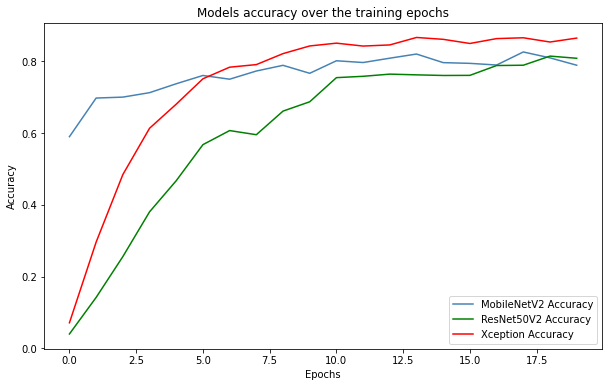

In [9]:
import matplotlib.pyplot as plt

epochs_range = range(20)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, mobileNetV2History['val_accuracy'], label='MobileNetV2 Accuracy', color='steelblue')
plt.plot(epochs_range, resNet50V2History['val_accuracy'], label='ResNet50V2 Accuracy', color='green')
plt.plot(epochs_range, xceptionHistory['val_accuracy'], label='Xception Accuracy', color='red')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Models accuracy over the training epochs')
plt.show()
